# Field Calibration analysis 

Five WeatherCubes are located at the Maryland Department of the Environment (MDE) Beltsville site, where ozone, NO$_2$, SO$_2$ (and many others) are sampled at second frequency. We compare the uncalibrated MDE data to our minute and 3-minute averaged data in this worksheet. 

In [2]:
# read in libraries, including
# AWS python library, boto3
%matplotlib inline 
# moved up
import boto3
from boto3.dynamodb.conditions import Key, Attr
# pandas, for data analysis
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
#plotting 
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')
import scipy.stats

# Get the service resource.
dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('BaltimoreOpenAir2017')

def easy_scatter(x,y,title='', xlabel='', ylabel='') : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    #r = np.corrcoef(x[ind], y[ind])[0,1]
    r,p = scipy.stats.pearsonr(x[ind], y[ind])
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r= %.2f'%r, xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p= %.2f'%p, xy=(.5, .7), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p

plt.rcParams.update({'font.size': 20})
plt.style.use('ggplot')
# read in metadata
meta = pd.read_csv('data/BaltimoreOpenAir2017_results.csv').set_index('id')

In [366]:
# read in the MDE data 
#### import MDE data 
#### note that this is not callibrated!!
mde = pd.read_csv('data/HU_minutedata.csv', header = 0,
                   #nrows = 10,
                   skipfooter=10,
                   parse_dates={'datetime': ['Date', 'Time']},
                   ).drop(0)
for col in [u'O3', u'SO2t(trace)', u'RH', u'Temp_10m', u'NO2(NOx)', 'Wind Speed V', 'BP']: 
    mde[col] = pd.to_numeric(mde[col], errors = 'coerce')
    mde[col] = mde[col].dropna()
if type(mde['datetime'].iloc[0])!= pd.tslib.Timestamp: 
    print('time is not timestamp, need to convert')
    mde.index = [pd.datetime.strptime(x, '%m/%d/%Y %I:%M %p') for x in mde['datetime'].values]
else:
    mde = mde.set_index('datetime', drop = False)
mde.head()

/Users/annascott2/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.


,datetime,O3,SO2t(trace),Wind Speed V,Wind Dir V,RH,Temp_10m,BP,NO2(NOx)
datetime,,,,,,,,,
2017-09-07 00:01:00,2017-09-07 00:01:00,12.0,0.0,0.5,330,93.0,57.0,1005.9,5.7
2017-09-07 00:02:00,2017-09-07 00:02:00,13.0,0.0,0.4,174,93.0,57.0,1005.9,5.8
2017-09-07 00:03:00,2017-09-07 00:03:00,11.0,0.0,0.7,200,93.0,57.0,1005.9,5.9
2017-09-07 00:04:00,2017-09-07 00:04:00,10.0,0.0,0.7,185,93.0,57.0,1005.9,5.9
2017-09-07 00:05:00,2017-09-07 00:05:00,10.0,0.0,0.8,189,93.0,57.0,1005.9,5.9


In [ ]:
# read in sensor data 
# read in data from WeatherCubes
ids = (10,11,12,13,14)
o3df = pd.DataFrame()
so2df = pd.DataFrame()
h2sdf = pd.DataFrame()
no2df = pd.DataFrame()

o3stddf = pd.DataFrame()
for sel_id in ids : 
    #sel_id = 10
    m_o3 = float(meta.loc[sel_id]['qr_ozone'][28:])
    m_no2 = float(meta.loc[sel_id]['qr_no2'][28:])
    m_h2s = float(meta.loc[sel_id]['qr_h2s'][28:])
    m_so2= float(meta.loc[sel_id]['qr_so2'][28:])

    response = table.query(
                KeyConditionExpression=Key('id').eq(str(sel_id)) & Key('timest').gt(20170908000015)
            )
    df = pd.DataFrame(response['Items'])
    ## convert post timestamp to datetime
    df['timest'] = [pd.to_datetime(str(date)[:-4], format = '%Y%m%d%H%M') for date in df['timest']]
    # read in batteryAV to get the time
    df[['something', 'HourMinute', 'MonthDay', 'AV', 'drop'] ] = df['battAV'].str.split(',').apply(pd.Series)

    df[['O3_avg', 'O3_std']]   = df[['O3_avg', 'O3_std']].astype(float)#.multiply(0.01)#* m_o3)
    df[['NO2_avg', 'NO2_std']] = df[['NO2_avg', 'NO2_std']].astype(float)#.multiply(0.01)#*m_no2)
    df[['SO2_avg', 'SO2_std']] = df[['SO2_avg', 'SO2_std']].astype(float)#.multiply(0.01)#* m_so2)
    df[['H2S_avg', 'H2S_std']] = df[['H2S_avg', 'H2S_std']].astype(float)#.multiply(0.01)#* m_h2s)

    # set up time index 
    date_index = []
    for date in df[['MonthDay', 'HourMinute']].values : 
        try: 
            if date[0] == '32767' : 
                date_index.append(np.nan)
            elif date[0] == '0' : 
                date_index.append(np.nan)
            else:
                date_index.append(pd.to_datetime('2017' +date[0]+date[1], format = '%Y%m%d%H%M'))
        except ValueError:  
            date_index.append(np.nan)

    df['date_index'] = date_index
    df.index = pd.DatetimeIndex(date_index, freq = '15Min')
    df = df.loc['2017-09-07':]
    #o3df = o3df.append(df['O3_avg'].rename(columns={"O3_avg": sel_id}))
    o3df[sel_id] = df['O3_avg'].resample('15Min').mean().rename(columns={"O3_avg": sel_id})
    o3stddf[sel_id] = df['O3_std'].resample('15Min').mean().rename(columns={"O3_std": sel_id})
    
    so2df[sel_id] = df['SO2_avg'].resample('15Min').mean().rename(columns={"SO2_avg": sel_id})
    h2sdf[sel_id] = df['H2S_avg'].resample('15Min').mean().rename(columns={"H2S_avg": sel_id})
    no2df[sel_id] = df['NO2_avg'].resample('15Min').mean().rename(columns={"NO2_avg": sel_id})

Let's look at the raw data from a sensor and compare it with the MDE station. 

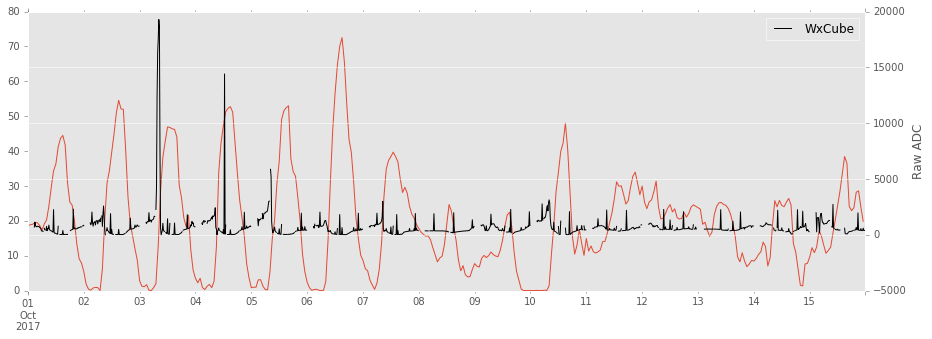

In [670]:
mde['O3'][s_time:e_time].resample('H').mean().plot(figsize = [15,5], label = 'MDE')
plt.ylabel('ppb')

o3df[12][s_time:e_time].plot(secondary_y = True, color = 'k', label = 'WxCube')
plt.legend(['WxCube'])
plt.ylabel('Raw ADC')


Raw data is very noisy. We should drop points around spikes of data when the variability is high. Also, we still see that the data is cutoff around 50 ppb or so. When we exclude these points, we get a reasonable correlation: 

(-19.339040082213053, -0.67222389476001254, 1.5983118095595041e-32)

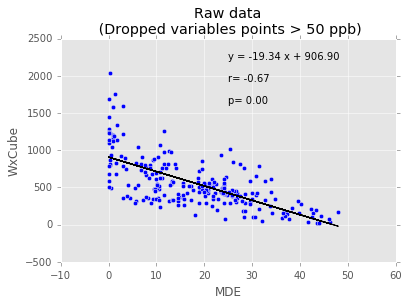

In [573]:
o3_thresh = 50
thresh = 300

x = mde['O3'][s_time:e_time].resample('H').mean()[( mde['O3'][s_time:e_time].resample('H').mean() < o3_thresh) &(o3df[12][s_time:e_time].resample('H').std()<thresh)]
y =  (o3df[12][s_time:e_time].resample('H').mean()[(mde['O3'][s_time:e_time].resample('H').mean() < o3_thresh) &(o3df[12][s_time:e_time].resample('H').std()<thresh)])
easy_scatter(x,y, 'Raw data\n (Dropped variables points > %i ppb)'%o3_thresh, 'MDE', 'WxCube')

Now, we add in the manufacturer's callibration code for our first pass at callibration. We correlate with the MDE data to calculate the offset of the manufacturer callibration code as well as the zero (which we have not yet applied). 

(1.7580945529284595, 0.67222389476001254, 1.5983118095595041e-32)

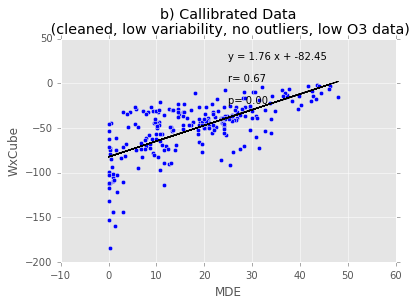

In [583]:
m = float(meta.loc[12]['qr_ozone'][28:])
adjusted = y/m
easy_scatter(x[adjusted.index], adjusted, 'b) Callibrated Data\n (cleaned, low variability, no outliers, low O3 data)', 'MDE', 'WxCube')

Use this data to establish the zero baseline and sensor offset. Now calculate the time-series using this data: 

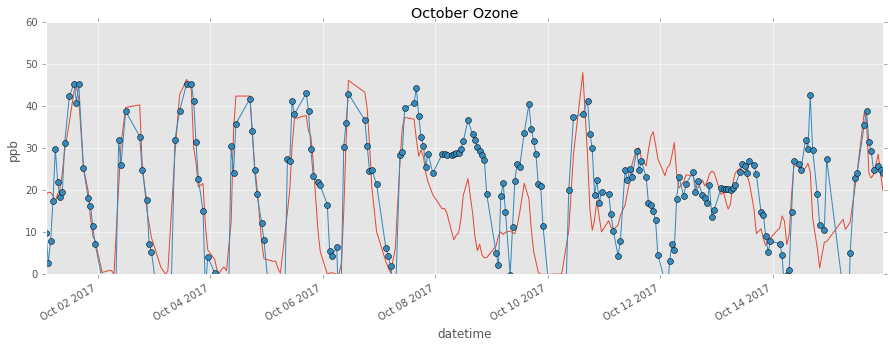

In [594]:
x.plot(figsize = [15,5])
(1/1.76*(y/m +82.45)).plot(style = '-o')
plt.ylim([0,60])
plt.title('October Ozone')
plt.ylabel('ppb')

This data does a great job capturing the diurnal cycle on most days. How good is the correlation? 

(1.0308762218300542, 0.55394985775378869, 0.00037516644553381152)

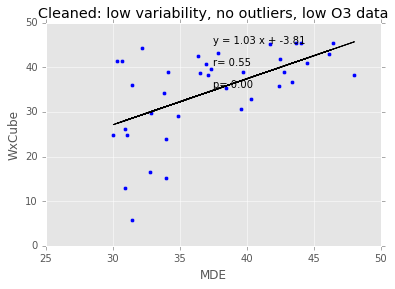

In [599]:
adjusted = (1/1.76*(y/m +82.45))
easy_scatter(x[x>30], 
             adjusted[x>30], 
             'Cleaned: low variability, no outliers, low O3 data',
             'MDE', 'WxCube')

Not great- we think we can do better by correcting for other chemicals and other sensitivities. 

In [626]:
regdf = pd.DataFrame()
col = 12
regdf['o3'] = adjusted
regdf['no2'] = no2df[s_time:e_time][col].resample('H').mean()
regdf['so2'] = so2df[s_time:e_time][col].resample('H').mean()
regdf['h2s'] = h2sdf[s_time:e_time][col].resample('H').mean()
regdf['tru_o3'] = mde['O3'][s_time:e_time].resample('H').mean()
regdf['rh'] = mde['RH'][s_time:e_time].resample('H').mean()
regdf['temp'] = mde['Temp_10m'][s_time:e_time].resample('H').mean()
deltaRH = (mde['RH'][s_time:e_time].iloc[1:].values - mde['RH'][s_time:e_time].iloc[:-1].values)
regdf['drh'] = pd.Series(deltaRH, index = mde[s_time:e_time].iloc[:-1].index).resample('H').mean()
regdf['stdo3'] = o3stddf[s_time:e_time][col].rolling(4).std().resample('H').mean()

result = sm.ols(formula="o3 ~ tru_o3+ so2+h2s + no2 + rh+ drh + temp + stdo3 ", data=regdf).fit()
print(result.params)
print(result.summary())

Intercept    55.219029
tru_o3        0.034574
so2          -0.061936
h2s          -0.034671
no2          -0.000214
rh           -0.060843
drh           9.617164
temp         -0.078478
stdo3         0.063418
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                     o3   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     128.8
Date:                Thu, 02 Nov 2017   Prob (F-statistic):           5.41e-74
Time:                        19:32:13   Log-Likelihood:                -702.53
No. Observations:                 206   AIC:                             1423.
Df Residuals:                     197   BIC:                             1453.
Df Model:                           8                                         
Covariance Type:            nonrobust                              

(2.0787292734925593, 0.72415002511107163, 1.6218223156394991e-24)

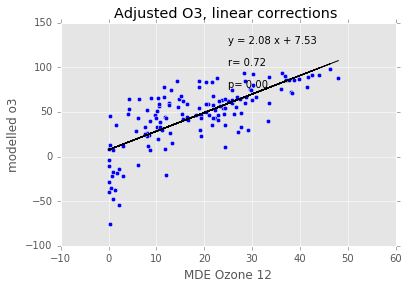

In [662]:
col = 12
#mod = -1/result.params['tru_o3'] *(regdf['o3'] + result.params['so2']*regdf['so2']+  result.params['h2s']*regdf['h2s']+ result.params['no2']*regdf['no2'] + result.params['stdo3']*regdf['stdo3']+ result.params['Intercept'])
mod =  (regdf['o3'] + result.params['so2']*regdf['so2']+  result.params['h2s']*regdf['h2s']+ result.params['no2']*regdf['no2'] + result.params['stdo3']*regdf['stdo3']+ result.params['Intercept'])
#mod = mod[mod > 0]
easy_scatter(regdf['tru_o3'].resample('2H').mean(),
             mod.resample('2H').mean(),
             'Adjusted O3, linear corrections ', 'MDE Ozone %s'%col, 'modelled o3')

This overestimates ozone by a factor of ~2. Correct this to get the final value: 

(0, 60)

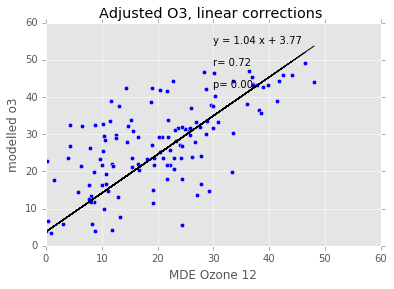

In [664]:
col = 12
#mod = -1/result.params['tru_o3'] *(regdf['o3'] + result.params['so2']*regdf['so2']+  result.params['h2s']*regdf['h2s']+ result.params['no2']*regdf['no2'] + result.params['stdo3']*regdf['stdo3']+ result.params['Intercept'])
mod = .5*(regdf['o3'] + result.params['so2']*regdf['so2']+  result.params['h2s']*regdf['h2s']+ result.params['no2']*regdf['no2'] + result.params['stdo3']*regdf['stdo3']+ result.params['Intercept'])
#mod = mod[mod > 0]
easy_scatter(regdf['tru_o3'].resample('2H').mean(),
             mod.resample('2H').mean(),
             'Adjusted O3, linear corrections ', 'MDE Ozone %s'%col, 'modelled o3')
plt.ylim([0,60])
plt.xlim([0,60])